In [1]:
"""
created on 12 Mar 2019

@author: Huan Zheng
"""
# Deep dream

'\ncreated on 12 Mar 2019\n\n@author: Huan Zheng\n'

# 用keras实现DeepDream
## 加载预训练的Inception V3模型

In [1]:
from keras.applications import inception_v3
from keras import backend as K

K.set_learning_phase(0)
# 我们不需要训练模型，所以在这个命令会禁用所有与训练有关的操作

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
# 构建不包括全连接层的inceptio V3网络。使用与训练的imageNet权重来加载模型

Using TensorFlow backend.


## 设置DeepDream配置

In [2]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

## 定义需要最大化的损失

In [9]:
layers_dict = dict([(layer.name, layer) for layer in model.layers])
# 创建有个实例，将层的名称映射成层的实例

loss = K.variable(0.) # 在定义损失时将层的贡献添加到这个标量变量中
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layers_dict[layer_name].output # 获取层的输出
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2:-2, :])) / scaling
    # 将该层特征的L2范数添加到loss中

## 梯度上升过程

In [24]:
dream = model.input # 这个张量用于保存生成的图像，即梦境图像

grads = K.gradients(loss, dream)[0] # 计算损失相对于梦境图像的梯度

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) # 将梯度标准化

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)
# 给定一张输出图像，设置一个kreas函数来获取损失值梯度和梯度值

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

## 辅助函数

In [25]:
import scipy
from keras.preprocessing import image
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2
    x += 0.5
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## 在多个连续尺度上运行梯度上升

In [28]:
import numpy as np

step = 0.01
num_octave = 3 # 运行梯度上升的尺度个数
octave_scale = 1.4 # 两个尺度之间的大小比例
iterations = 20 # 在每个尺度上运行梯度上升的步数

max_loss = 10. # 如果损失增大到大于10，终端梯度上升过程，一面得到丑陋的伪影

# base_image_path = 'yuner.jpg'
base_image_path = 'yuner2.jpeg'

img = preprocess_image(base_image_path) # 将基础图像加载陈一个numpy数组

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    
successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1] # 将形状列表反转，变为升序
    
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])
    
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape) # 将梦境放大
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape) # 将原始图像的较小版本放大
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_svale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (634, 357)
...Loss value at 0 : 2.0683825
...Loss value at 1 : 2.574534
...Loss value at 2 : 3.3188527
...Loss value at 3 : 4.0982337
...Loss value at 4 : 4.8535166
...Loss value at 5 : 5.593744
...Loss value at 6 : 6.3051076
...Loss value at 7 : 6.989859
...Loss value at 8 : 7.650686
...Loss value at 9 : 8.29015
...Loss value at 10 : 8.891383
...Loss value at 11 : 9.48118


F:\Anaconda\Anaconda3.5\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Processing image shape (1244, 700)
...Loss value at 0 : 2.5132315
...Loss value at 1 : 3.297444
...Loss value at 2 : 4.113148
...Loss value at 3 : 4.9835334
...Loss value at 4 : 5.867912
...Loss value at 5 : 6.7761602
...Loss value at 6 : 7.6778283
...Loss value at 7 : 8.550023
...Loss value at 8 : 9.455927


## 结果可视化

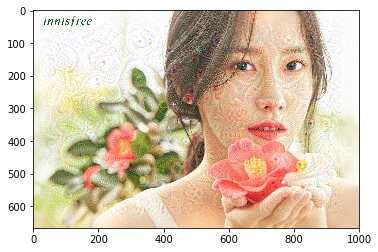

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

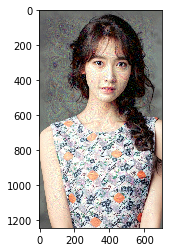

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(deprocess_image(np.copy(img)))
plt.show()